In [1]:
%config Completer.use_jedi = False

import tensorflow as tf
from tensorflow.keras import regularizers
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
BUFFER_SIZE = 24
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512
OUTPUT_CHANNELS = 3
path = 'Dir of processed images'

In [3]:
def load_image(path):
    #Read image
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img)
    
    w = tf.shape(img)[1] // 2
    
    img_hr = img[:, :w, :]
    img_lr = img[:, w:, :]
    
    #Convert to tensor - float32
    img_hr = tf.image.convert_image_dtype(img_hr, tf.float32)
    img_lr = tf.image.convert_image_dtype(img_lr, tf.float32)
    
    return img_hr, img_lr

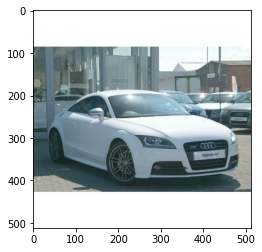

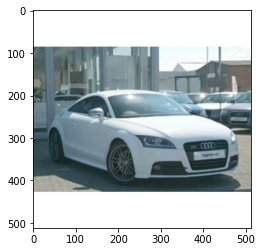

In [4]:
img_hr, img_lr = load_image(path + 're_train/1.jpeg')

plt.figure()
plt.imshow(img_hr)

plt.figure()
plt.imshow(img_lr)

In [5]:
def resize(img_hr,img_lr,h,w):
    img_hr = tf.image.resize(img_hr,[h,w],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    img_lr = tf.image.resize(img_lr,[h,w],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return img_hr,img_lr

In [6]:
def random_crop(img_hr,img_lr):
    img_stacked = tf.stack([img_hr, img_lr], axis=0)
    img_crop = tf.image.random_crop(img_stacked, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    
    return img_crop[0],img_crop[1]

In [7]:
@tf.function()
def random_jitter(img_hr,img_lr):
    
    img_hr,img_lr = resize(img_hr,img_lr,IMG_HEIGHT, IMG_WIDTH)
    
    img_hr,img_lr = random_crop(img_hr,img_lr)
    
    if tf.random.uniform([]) > 0.5:
        img_hr = tf.image.flip_left_right(img_hr)
        img_lr = tf.image.flip_left_right(img_lr)
    return img_hr,img_lr

In [8]:
def load_img_dataset(path):
    img_hr,img_lr = load_image(path)
    #img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    img_hr,img_lr = random_jitter(img_hr,img_lr)
    #img = normalize(img)
    return img_lr,img_hr

In [9]:
train_dataset = tf.data.Dataset.list_files(path + 're_train/*.jpeg')
train_dataset = train_dataset.map(load_img_dataset,
                                  num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [10]:
def DownLayer(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0,0.02)

    result = tf.keras.Sequential()

    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2,padding='same',
                              kernel_initializer = initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [11]:
layer_down = DownLayer(16,3)
layer_down = layer_down(tf.expand_dims(img_hr,0))
layer_down.shape

TensorShape([1, 256, 256, 16])

In [12]:
def UpLayer(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0,0.02)

    result = tf.keras.Sequential()

    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                              kernel_initializer=initializer,use_bias=False))
    
    
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())
    return result

In [13]:
layer_up = UpLayer(16,3)
layer_up = layer_up(layer_down)
layer_up.shape

TensorShape([1, 512, 512, 16])

In [14]:
def U_net():
    inputs = tf.keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,3])
    
    down_stack=[
        DownLayer(64,4,apply_batchnorm=False),#[batch_size, 256, 256, 64]
        DownLayer(128,4,),#[batch_size, 128, 256, 64]
        DownLayer(256,4,),#[batch_size, 64, 256, 64]
        DownLayer(512,4,),#[batch_size, 32, 256, 64]
        DownLayer(512,4,),#[batch_size, 16, 256, 64]
        DownLayer(512,4,),#[batch_size, 16, 256, 64]
        DownLayer(512,4,),#[batch_size, 16, 256, 64]
    ]
    
    up_stack=[
        UpLayer(512,4,apply_dropout=True),#[batch_size, 32, 256, 64]
        UpLayer(512,4,apply_dropout=True),#[batch_size, 32, 256, 64]
        UpLayer(512,4,apply_dropout=True),#[batch_size, 32, 256, 64]
        UpLayer(256,4,),#[batch_size, 64, 256, 64]
        UpLayer(128,4,),#[batch_size, 128, 256, 64]
        UpLayer(64,4,),#[batch_size, 256, 256, 64]
    ]
    
    initializer = tf.random_normal_initializer(0.,0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',
                                          kernel_initializer=initializer, activation='relu')
    
    
    x = inputs
    skips = []
    
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = list(reversed(skips[:-1]))
    
    for up,skip in zip(up_stack,skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x,skip])

    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

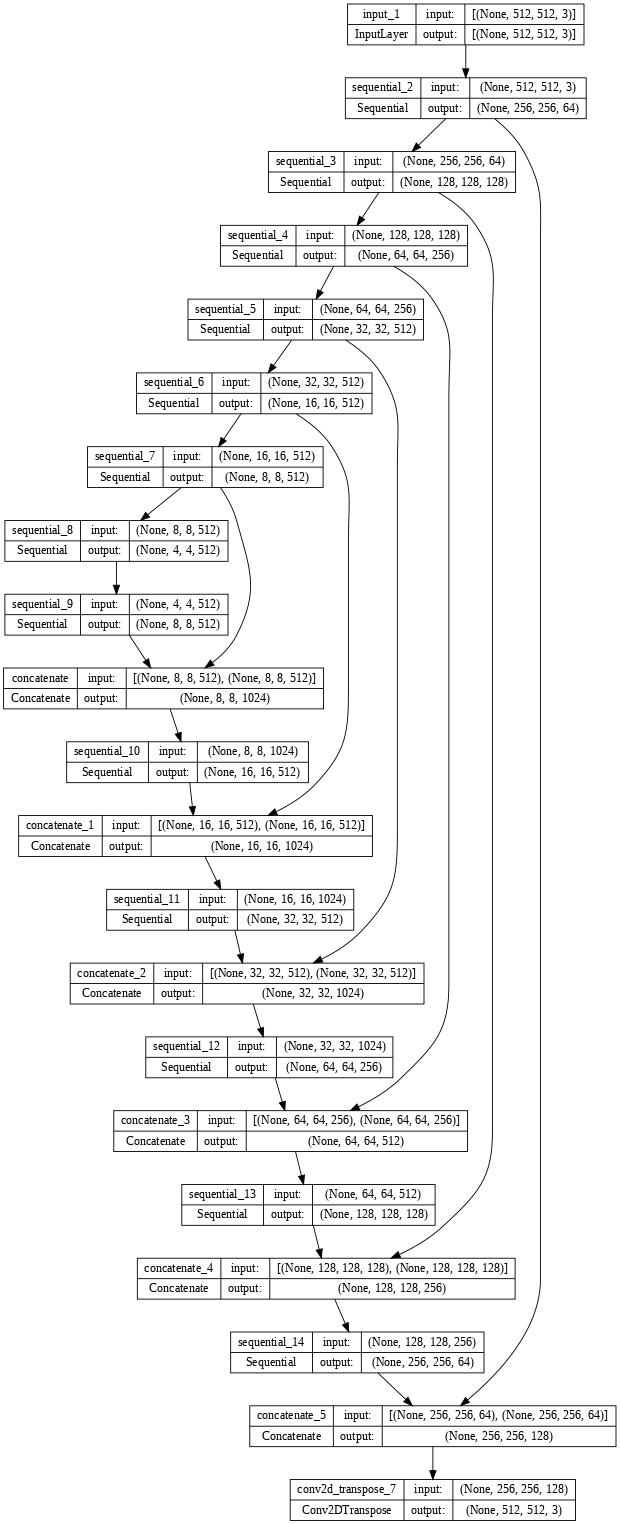

In [15]:
u_net = U_net()
tf.keras.utils.plot_model(u_net, show_shapes=True, dpi=64)

In [16]:
u_net.compile(optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5), loss='mean_squared_error')

In [17]:
u_net.fit(train_dataset,epochs=30,steps_per_epoch=256,)

Epoch 1/30
256/256 [==============================] - 152s 563ms/step - loss: 0.0251
Epoch 2/30
256/256 [==============================] - 32s 124ms/step - loss: 0.0030
Epoch 3/30
256/256 [==============================] - 32s 125ms/step - loss: 0.0023
Epoch 4/30
256/256 [==============================] - 32s 127ms/step - loss: 0.0019
Epoch 5/30
256/256 [==============================] - 33s 128ms/step - loss: 0.0016
Epoch 6/30
256/256 [==============================] - 33s 129ms/step - loss: 0.0013
Epoch 7/30
256/256 [==============================] - 33s 129ms/step - loss: 0.0012
Epoch 8/30
256/256 [==============================] - 33s 129ms/step - loss: 0.0011
Epoch 9/30
256/256 [==============================] - 33s 129ms/step - loss: 0.0010
Epoch 10/30
256/256 [==============================] - 33s 129ms/step - loss: 9.8691e-04
Epoch 11/30
256/256 [==============================] - 33s 129ms/step - loss: 9.8671e-04
Epoch 12/30
256/256 [==============================] - 33s 129ms/

In [18]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    
    title = ['input_image', 'target_image', 'prediction']
    
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title[i])
        
        plt.imshow(display_list[i])
        plt.axis('off')
    
    plt.show()

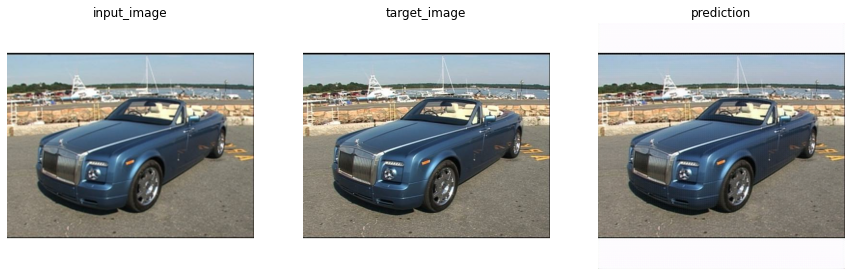

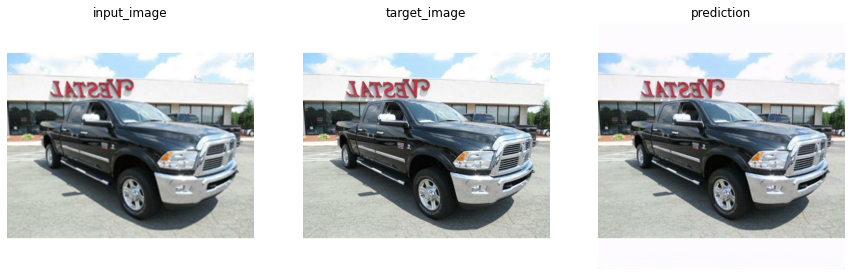

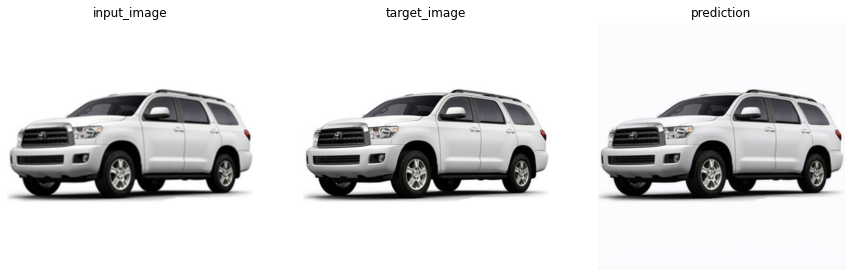

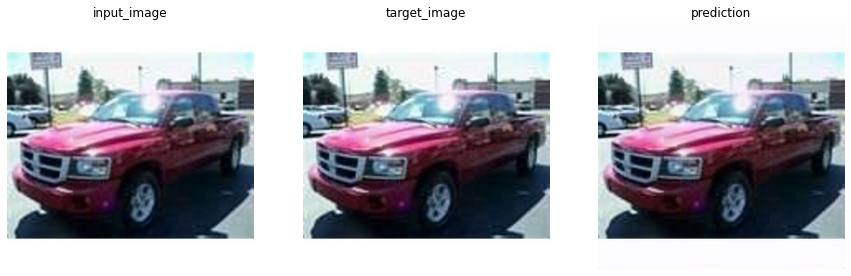

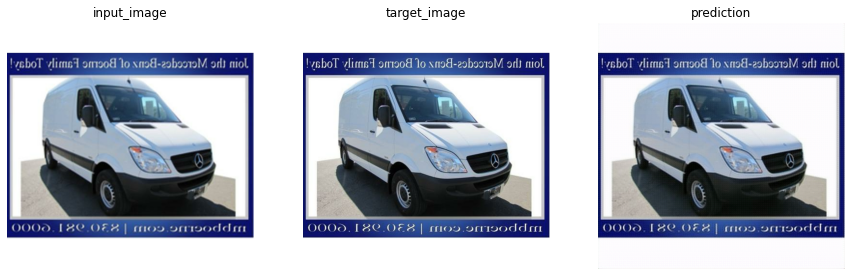

In [20]:
for inp, tar in train_dataset.take(5):
    generate_images(u_net, inp, tar)

In [22]:
tf.keras.models.save_model(u_net, path)